In [2]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from graph_toolset import coreness, degs
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [3]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [4]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def plot_2d(alphas, bs, data, last, keys, title):
    fig, axs = plt.subplots(ncols=len(keys), figsize=(6 * len(keys), 5))
    
    for key, ax in zip(keys, axs):
        cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 3, data[key])
        cur = np.apply_along_axis(np.mean, 0, cur)
        
        CSF = ax.contourf(bs, alphas, cur, levels=100, label=str(key))
        # CS = ax.contour(x, y, z, levels=levels, colors='black', linestyles='dashed')
        fig.colorbar(CSF, ax=ax, orientation='vertical', fraction=.1)
        # plt.clabel(CS, fmt='%1.1f', colors='k', fontsize=14)  # contour line labels
        ax.set_title(key)
        # ax.legend()
        
    fig.suptitle(title)
    plt.show()

In [8]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [9]:
def ER(t):
    return ErdosRenyi(*t)

n = 500
graphs = Pool(32).map(ER, [(n, 4. / n) for _ in range(500)])

In [23]:
bs = partition(0, 8, 32)
alphas = np.concatenate((partition(0, .15, 20), []))
alphas

array([0.0075, 0.015 , 0.0225, 0.03  , 0.0375, 0.045 , 0.0525, 0.06  ,
       0.0675, 0.075 , 0.0825, 0.09  , 0.0975, 0.105 , 0.1125, 0.12  ,
       0.1275, 0.135 , 0.1425, 0.15  ])

In [68]:
res_mono = calc('mono', alphas, bs, graphs[:10], 1000, set_builder=total, keys=['rho', 'l'])

#1 passed in 488.7247848510742,  projected end in 73.30872945785522 minutes
#2 passed in 494.4298415184021,  projected end in 65.54403285980224 minutes
#3 passed in 485.1335015296936,  projected end in 57.10043792194791 minutes
#4 passed in 498.05789041519165,  projected end in 49.15893582701683 minutes
#5 passed in 498.14942502975464,  projected end in 41.075145351886746 minutes
#6 passed in 497.5447371006012,  projected end in 32.91173348426819 minutes
#7 passed in 493.1708519458771,  projected end in 24.68021320104599 minutes
#8 passed in 496.55428314208984,  projected end in 16.465775286157925 minutes
#9 passed in 483.26514434814453,  projected end in 8.21306438755106 minutes
#10 passed in 497.5969274044037,  projected end in 0.0 minutes
time elapsed = 4932.712033987045


<IPython.core.display.Javascript object>


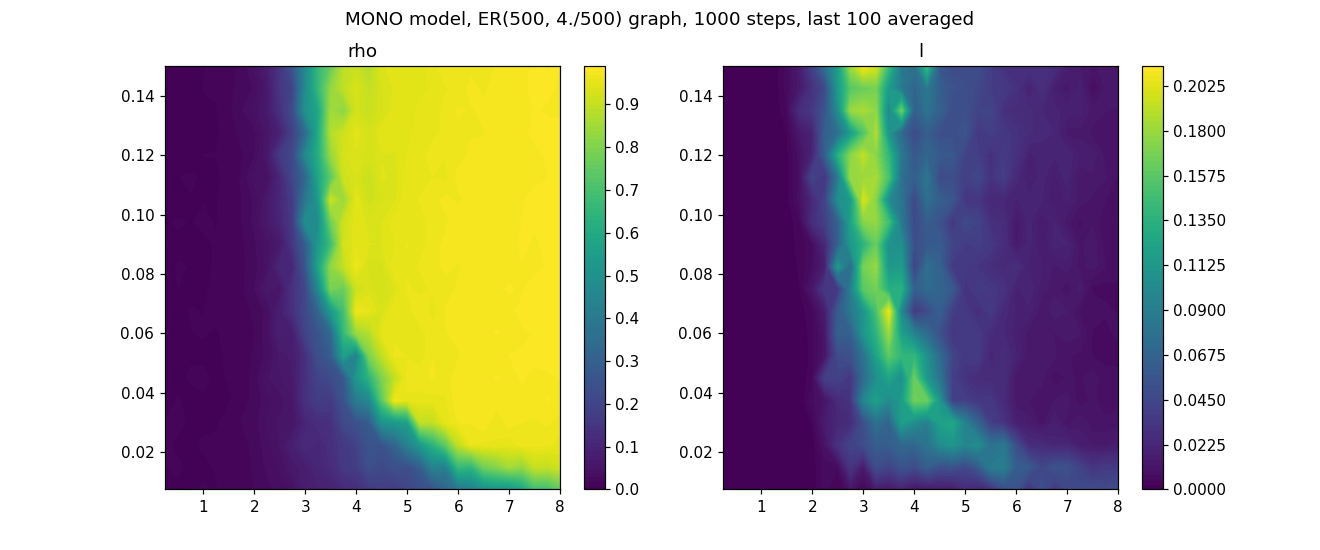

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  


In [70]:
plot_2d(alphas, bs, res_mono, 100, ['rho', 'l'], 'MONO model, ER(500, 4./500) graph, 1000 steps, last 100 averaged')

In [69]:
res_sum = calc('sum', alphas, bs, graphs[:10], 1000, set_builder=total, keys=['rho', 'l'])

#1 passed in 617.0011277198792,  projected end in 92.5501759171486 minutes
#2 passed in 619.5958254337311,  projected end in 82.44000557263692 minutes
#3 passed in 622.3071756362915,  projected end in 72.2909824623002 minutes
#4 passed in 618.0563843250275,  projected end in 61.924264419078824 minutes
#5 passed in 629.3517625331879,  projected end in 51.77210078239441 minutes
#6 passed in 634.9965748786926,  projected end in 41.57026908927494 minutes
#7 passed in 618.6236412525177,  projected end in 31.142509862354824 minutes
#8 passed in 634.1718657016754,  projected end in 20.808858811855316 minutes
#9 passed in 614.8560018539429,  projected end in 10.38700836499532 minutes
#10 passed in 628.1621785163879,  projected end in 0.0 minutes
time elapsed = 6237.212346315384


<IPython.core.display.Javascript object>


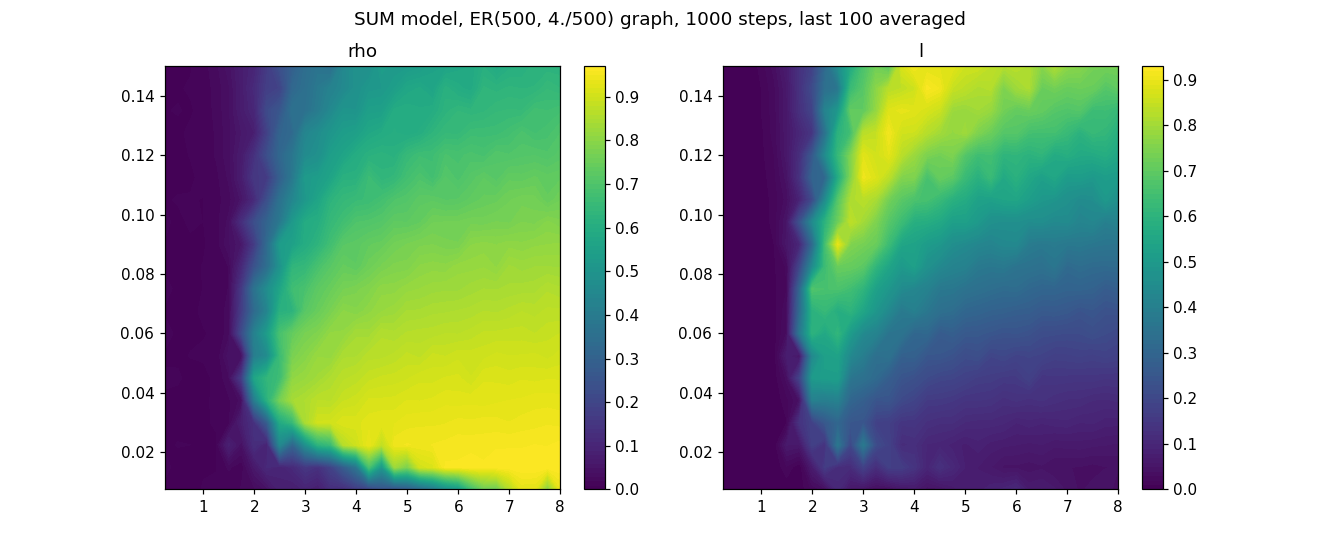

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  


In [71]:
plot_2d(alphas, bs, res_sum, 100, ['rho', 'l'], 'SUM model, ER(500, 4./500) graph, 1000 steps, last 100 averaged')

In [9]:
def SF(t):
    return ScaleFree(*t)

graphs = Pool(32).map(SF, [(500, 4) for _ in range(500)])

Process ForkPoolWorker-50:
Process ForkPoolWorker-38:
Process ForkPoolWorker-45:
Process ForkPoolWorker-61:
Process ForkPoolWorker-42:
Process ForkPoolWorker-51:
Process ForkPoolWorker-46:
Process ForkPoolWorker-40:
Process ForkPoolWorker-44:
Process ForkPoolWorker-36:
Process ForkPoolWorker-62:
Process ForkPoolWorker-33:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-34:
Process ForkPoolWorker-64:
Process ForkPoolWorker-39:
Process ForkPoolWorker-41:
Process ForkPoolWorker-49:
Process ForkPoolWorker-54:
Process ForkPoolWorker-47:
Process ForkPoolWorker-48:
Process ForkPoolWorker-37:
Process ForkPoolWorker-60:
Process ForkPoolWorker-58:
Process ForkPoolWorker-55:
Process ForkPoolWorker-52:
Process ForkPoolWorker-43:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-57:
Process ForkPoolWorker-63:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [10]:
def SW(t):
    return SmallWorld(*t)

graphs = Pool(32).map(SW, [(500, 5, .5) for _ in range(500)])

Process ForkPoolWorker-86:
Process ForkPoolWorker-66:
Process ForkPoolWorker-89:
Process ForkPoolWorker-78:
Process ForkPoolWorker-76:
Process ForkPoolWorker-65:
Process ForkPoolWorker-93:
Process ForkPoolWorker-73:
Process ForkPoolWorker-70:
Process ForkPoolWorker-96:
Process ForkPoolWorker-80:
Process ForkPoolWorker-81:
Process ForkPoolWorker-94:
Process ForkPoolWorker-95:
Process ForkPoolWorker-87:
Process ForkPoolWorker-88:
Process ForkPoolWorker-85:
Process ForkPoolWorker-74:
Traceback (most recent call last):


In [15]:
res_fun = calc('fun', alphas, bs, graphs[:10], 1000, set_builder=total, keys=['rho', 'l'])

#1 passed in 338.88642930984497,  projected end in 50.83297033309937 minutes
#2 passed in 337.8449807167053,  projected end in 45.11573224067688 minutes
#3 passed in 338.66156578063965,  projected end in 39.48782040410571 minutes
#4 passed in 337.5253164768219,  projected end in 33.823213344812395 minutes
#5 passed in 336.57423520088196,  projected end in 28.15842136939367 minutes
#6 passed in 337.33745861053467,  projected end in 22.520499359236826 minutes
#7 passed in 338.4641373157501,  projected end in 16.895085140636986 minutes
#8 passed in 339.0810570716858,  projected end in 11.26831543246905 minutes
#9 passed in 337.6686906814575,  projected end in 5.633459058514347 minutes
#10 passed in 338.56488156318665,  projected end in 0.0 minutes
time elapsed = 3380.7112135887146


Process ForkPoolWorker-132:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-130:
Process ForkPoolWorker-134:
Process ForkPoolWorker-131:
Process ForkPoolWorker-133:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Process ForkPoolWorker-159:


<IPython.core.display.Javascript object>


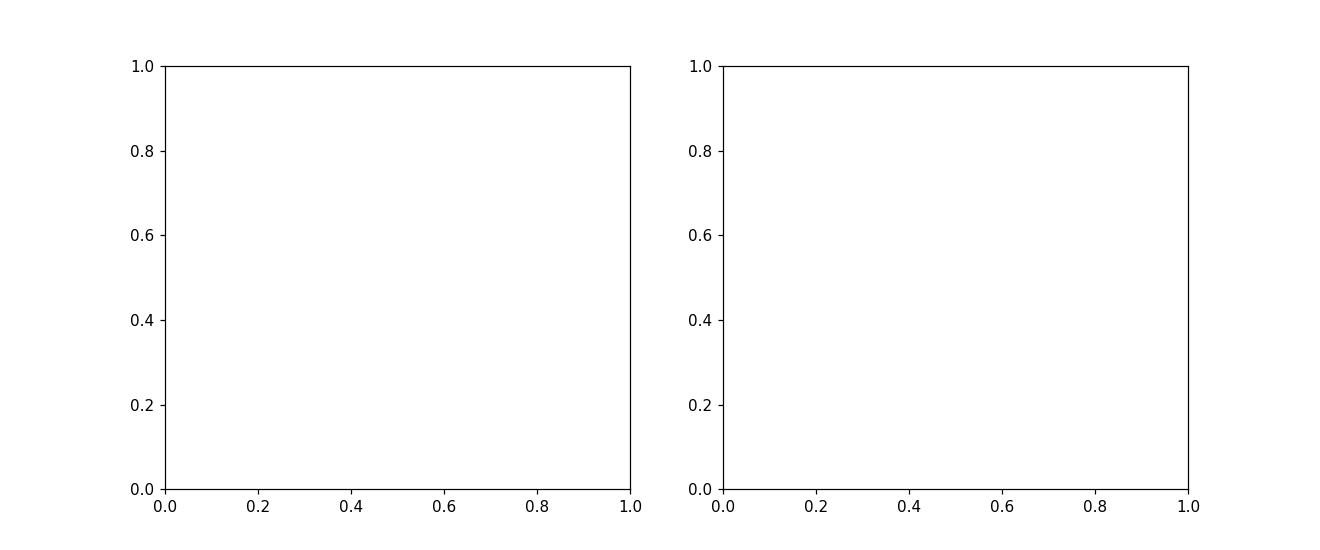

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 32)

In [22]:
plot_2d(alphas, bs, res_fun, 100, ['rho', 'l'], 'ORIGINAL model, ER(500, 4./500) graph, 1000 steps, last 100 averaged')

In [31]:
alpha = [.10]
bs = partition(0, 8, 32)

In [26]:
res_fun = calc('fun', alpha, bs, graphs[:100], 1000, set_builder=total, keys=['rho'])

#1 passed in 61.47981834411621,  projected end in 101.44176714420318 minutes
#2 passed in 31.205029010772705,  projected end in 75.69548074007034 minutes
#3 passed in 31.28468632698059,  projected end in 66.80823383993572 minutes
#4 passed in 31.01470160484314,  projected end in 61.995875453948976 minutes
#5 passed in 31.362780809402466,  projected end in 59.01188991467158 minutes
#6 passed in 31.15622591972351,  projected end in 56.79473154279921 minutes
#7 passed in 30.931946754455566,  projected end in 55.012762972286765 minutes
#8 passed in 31.128572940826416,  projected end in 53.58508043686549 minutes
#9 passed in 31.170029878616333,  projected end in 52.36637950738271 minutes
#10 passed in 30.874215841293335,  projected end in 51.24310734272003 minutes
#11 passed in 31.892234086990356,  projected end in 50.367803037889075 minutes
#12 passed in 31.35418963432312,  projected end in 49.48401513894399 minutes
#13 passed in 31.164705991744995,  projected end in 48.63465013687427 minu

<IPython.core.display.Javascript object>


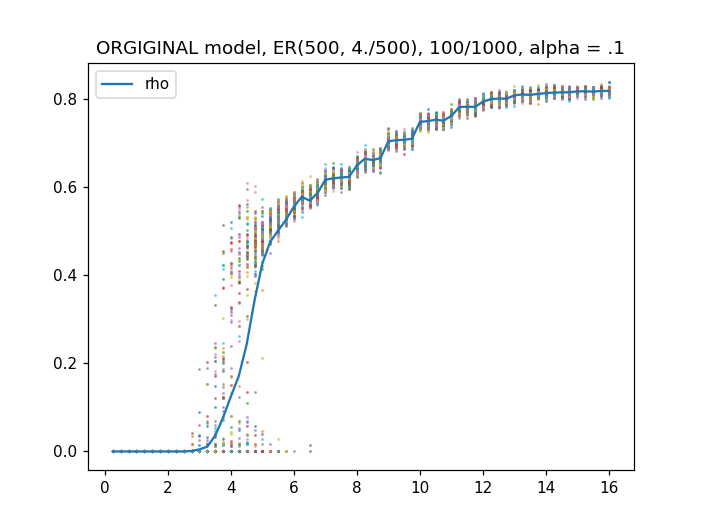

In [33]:
plot_means(partition(0, 16, 64), cut_alpha(res_fun, 0), 100, ['rho'], 'ORGIGINAL model, ER(500, 4./500), 100/1000, alpha = .1', show_data=True)

In [34]:
res_mono = calc('mono', alpha, bs, graphs[:100], 1000, set_builder=total, keys=['rho'])

#1 passed in 31.428109884262085,  projected end in 51.85644346475601 minutes
#2 passed in 31.173654556274414,  projected end in 51.127864901224775 minutes
#3 passed in 31.211533308029175,  projected end in 50.557483730051246 minutes
#4 passed in 31.009840965270996,  projected end in 49.93196773529053 minutes
#5 passed in 31.050270318984985,  projected end in 49.36260720094045 minutes
#6 passed in 30.96498966217041,  projected end in 48.78804526196586 minutes
#7 passed in 31.130343198776245,  projected end in 48.266789730957576 minutes
#8 passed in 31.589756965637207,  projected end in 47.83420296510061 minutes
#9 passed in 31.240777492523193,  projected end in 47.32198892081225 minutes
#10 passed in 30.980438470840454,  projected end in 46.769042801857 minutes
#11 passed in 31.309808254241943,  projected end in 46.26724221959259 minutes
#12 passed in 30.880521535873413,  projected end in 45.70952868991427 minutes
#13 passed in 30.953107118606567,  projected end in 45.16654468407998 min

<IPython.core.display.Javascript object>


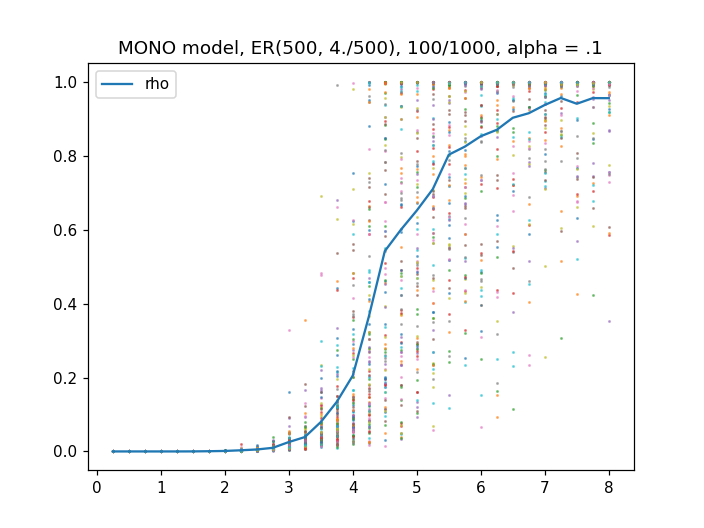

In [35]:
plot_means(bs, cut_alpha(res_mono, 0), 100, ['rho'], 'MONO model, ER(500, 4./500), 100/1000, alpha = .1', show_data=True)

In [41]:
res_sum = calc('sum', alpha, partition(0, 16, 64), graphs[:50], 1000, set_builder=total, keys=['rho'])

#1 passed in 84.91516709327698,  projected end in 69.34742715358735 minutes
#2 passed in 85.69782972335815,  projected end in 68.24615898132325 minutes
#3 passed in 84.81242108345032,  projected end in 66.69531374242571 minutes
#4 passed in 87.28883147239685,  projected end in 65.6878180861473 minutes
#5 passed in 87.80864357948303,  projected end in 64.57961926460266 minutes
#6 passed in 93.03402280807495,  projected end in 63.991504057248434 minutes
#7 passed in 85.169762134552,  projected end in 62.32314318021138 minutes
#8 passed in 85.41465640068054,  projected end in 60.73843369781971 minutes
#9 passed in 94.18381786346436,  projected end in 59.85533276575583 minutes
#10 passed in 96.39987969398499,  projected end in 58.98265604972839 minutes
#11 passed in 86.304860830307,  projected end in 57.3800047581846 minutes
#12 passed in 85.11402773857117,  projected end in 55.74185601207945 minutes
#13 passed in 84.72076272964478,  projected end in 54.11882494993699 minutes
#14 passed in

<IPython.core.display.Javascript object>


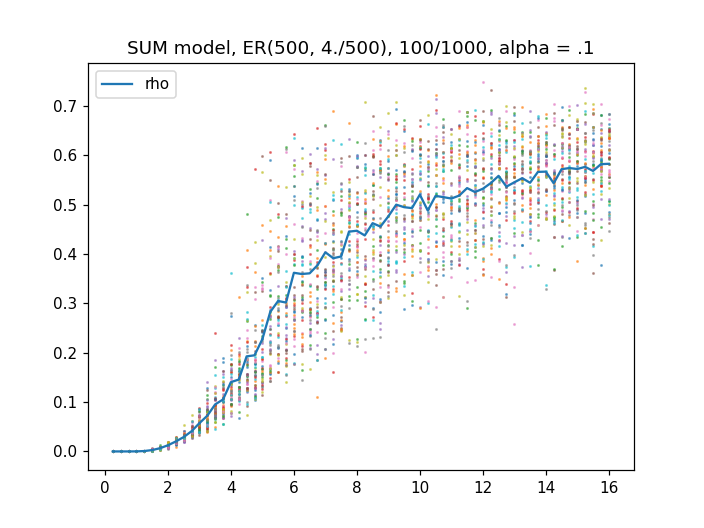

In [43]:
plot_means(partition(0, 16, 64), cut_alpha(res_sum, 0), 10, ['rho'], 'SUM model, ER(500, 4./500), 100/1000, alpha = .10', show_data=True)

In [48]:
res_sum = calc('sum', [.05], partition(0, 8, 32), graphs[:100], 100, set_builder=total, keys=['rho'])

#1 passed in 4.452410459518433,  projected end in 7.34654688835144 minutes
#2 passed in 4.37582802772522,  projected end in 7.2114639242490135 minutes
#3 passed in 4.359787940979004,  projected end in 7.108455958631304 minutes
#4 passed in 4.339600563049316,  projected end in 7.01256799697876 minutes
#5 passed in 4.3321051597595215,  projected end in 6.923751552899678 minutes
#6 passed in 4.385019779205322,  projected end in 6.854276170995501 minutes
#7 passed in 4.375286340713501,  projected end in 6.78160798719951 minutes
#8 passed in 4.419350862503052,  projected end in 6.717358744144439 minutes
#9 passed in 4.433532953262329,  projected end in 6.653367771042718 minutes
#10 passed in 4.388394594192505,  projected end in 6.580630123615265 minutes
#11 passed in 4.392880439758301,  projected end in 6.508404843373731 minutes
#12 passed in 4.265094041824341,  projected end in 6.4204409148958 minutes
#13 passed in 4.298726797103882,  projected end in 6.3387911530641405 minutes
#14 passed 

<IPython.core.display.Javascript object>


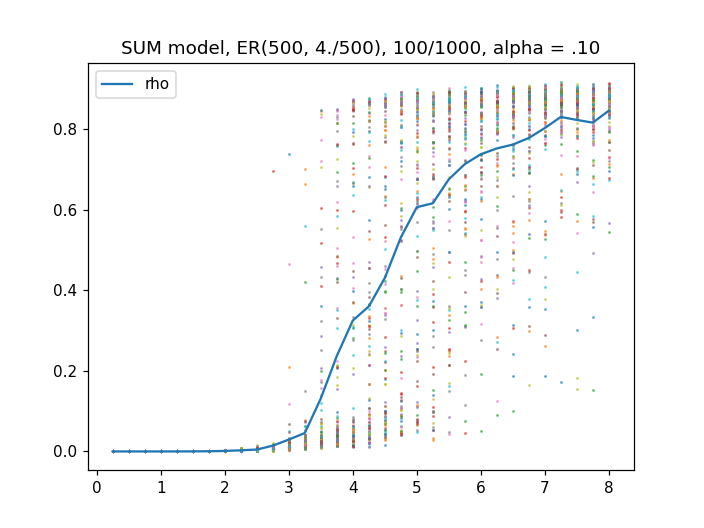

In [49]:
plot_means(partition(0, 8, 32), cut_alpha(res_sum, 0), 10, ['rho'], 'SUM model, ER(500, 4./500), 100/1000, alpha = .10', show_data=True)

In [52]:
graphs23 = Pool(32).map(GraphByDegrees, [{2: 300, 3: 300} for _ in range(500)])

In [62]:
res = calc('fun', [.10], partition(0, 8, 32), graphs23[:20], 200, set_builder=total, keys=['rho'])

#1 passed in 1.5371818542480469,  projected end in 0.48678482373555504 minutes
#2 passed in 1.5259888172149658,  projected end in 0.4599532842636108 minutes
#3 passed in 1.5663022994995117,  projected end in 0.437605685657925 minutes
#4 passed in 1.5326793193817139,  projected end in 0.41112343470255536 minutes
#5 passed in 1.5113003253936768,  projected end in 0.3839428901672363 minutes
#6 passed in 1.5293967723846436,  projected end in 0.35812645620769923 minutes
#7 passed in 1.5551328659057617,  projected end in 0.333198052360898 minutes
#8 passed in 1.5405192375183105,  projected end in 0.3076515793800354 minutes
#9 passed in 1.5466468334197998,  projected end in 0.28220454189512467 minutes
#10 passed in 1.524339199066162,  projected end in 0.2563136617342631 minutes
#11 passed in 1.5131654739379883,  projected end in 0.23035584796558725 minutes
#12 passed in 1.4998059272766113,  projected end in 0.20436973306867812 minutes
#13 passed in 1.5090272426605225,  projected end in 0.1786

<IPython.core.display.Javascript object>


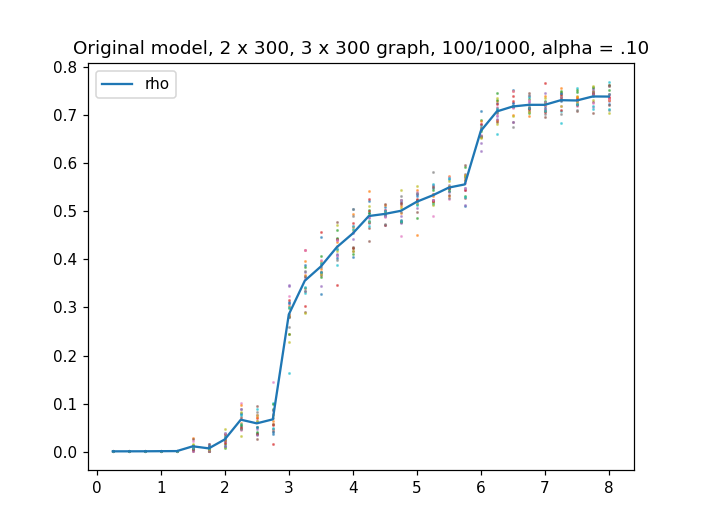

In [63]:
plot_means(partition(0, 8, 32), cut_alpha(res, 0), 200, ['rho'], 'Original model, 2 x 300, 3 x 300 graph, 100/1000, alpha = .10', show_data=True)

<IPython.core.display.Javascript object>


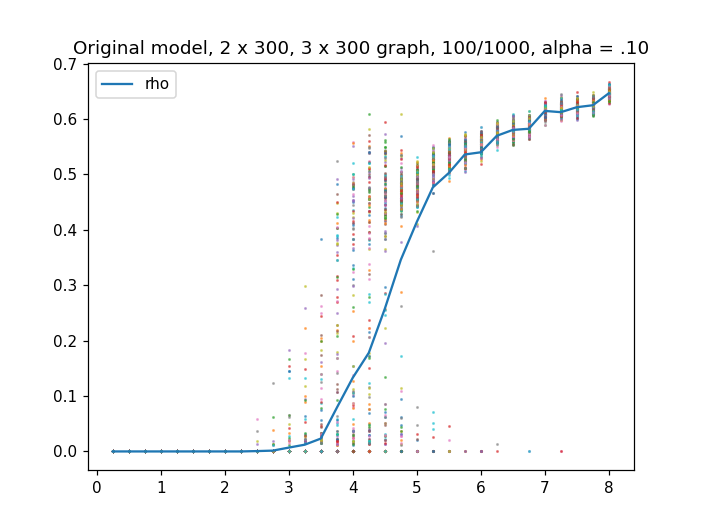

In [59]:
plot_means(partition(0, 8, 32), cut_alpha(res, 0), 200, ['rho'], 'Original model, 2 x 300, 3 x 300 graph, 100/1000, alpha = .10', show_data=True)

In [64]:
res2 = calc('fun', [.10], partition(0, 8, 32), graphs23[:40], 1000, set_builder=total, keys=['rho'])

#1 passed in 7.711082220077515,  projected end in 5.012225449085236 minutes
#2 passed in 7.598779678344727,  projected end in 4.849052933851878 minutes
#3 passed in 7.896404027938843,  projected end in 4.770935532781812 minutes
#4 passed in 7.708564758300781,  projected end in 4.6379102110862735 minutes
#5 passed in 7.690315246582031,  projected end in 4.504576202233633 minutes
#6 passed in 7.685594320297241,  projected end in 4.37248995701472 minutes
#7 passed in 7.634684085845947,  projected end in 4.237540805339814 minutes
#8 passed in 7.475170850753784,  projected end in 4.093995555241903 minutes
#9 passed in 7.632230043411255,  projected end in 3.9635759194691977 minutes
#10 passed in 7.626932621002197,  projected end in 3.8335336089134215 minutes
#11 passed in 7.725162029266357,  projected end in 3.708337696754571 minutes
#12 passed in 7.929123163223267,  projected end in 3.5904876073201497 minutes
#13 passed in 7.631108522415161,  projected end in 3.4601343870162964 minutes
#14 

<IPython.core.display.Javascript object>


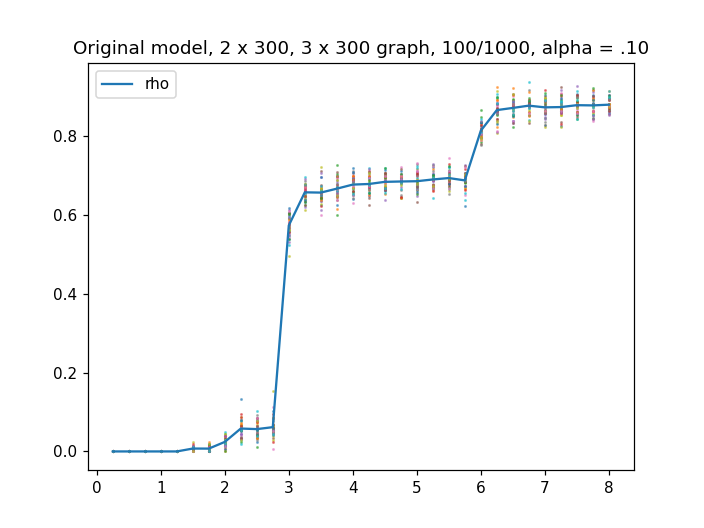

In [65]:
plot_means(partition(0, 8, 32), cut_alpha(res2, 0), 100, ['rho'], 'Original model, 2 x 300, 3 x 300 graph, 100/1000, alpha = .10', show_data=True)

<IPython.core.display.Javascript object>


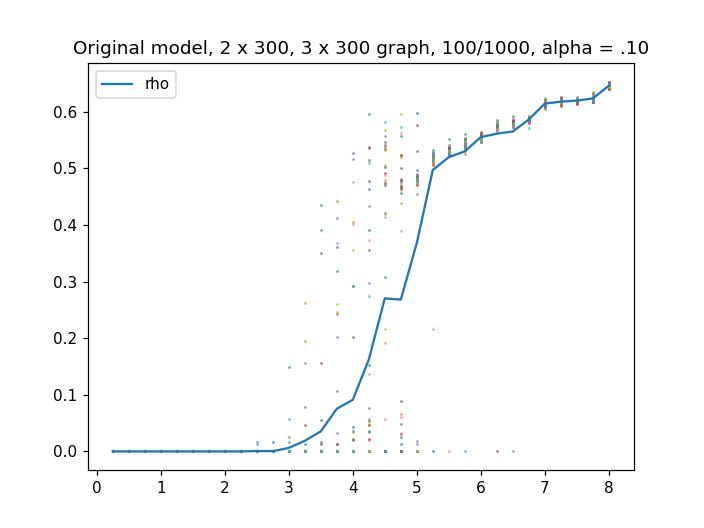

In [61]:
plot_means(partition(0, 8, 32), cut_alpha(res2, 0), 2000, ['rho'], 'Original model, 2 x 300, 3 x 300 graph, 100/1000, alpha = .10', show_data=True)

In [79]:
res = calc('mono', [.10], partition(0, 8, 32), graphs[:40], 1000, set_builder=total, keys=['rho'])

#1 passed in 31.345972537994385,  projected end in 20.37490818500519 minutes
#2 passed in 32.15922546386719,  projected end in 20.110644062360127 minutes
#3 passed in 32.1855366230011,  projected end in 19.67075943549474 minutes
#4 passed in 30.90111780166626,  projected end in 18.989853501319885 minutes
#5 passed in 31.319014310836792,  projected end in 18.42393411397934 minutes
#6 passed in 31.784106731414795,  projected end in 17.916573193338184 minutes
#7 passed in 31.041311264038086,  projected end in 17.344425724233897 minutes
#8 passed in 31.477415084838867,  projected end in 16.81510877609253 minutes
#9 passed in 31.705429792404175,  projected end in 16.299846818712023 minutes
#10 passed in 31.779356479644775,  projected end in 15.785730016231536 minutes
#11 passed in 32.29149532318115,  projected end in 15.29120767694531 minutes
#12 passed in 30.976291179656982,  projected end in 14.738270170158811 minutes
#13 passed in 31.313249111175537,  projected end in 14.202639338603385 

<IPython.core.display.Javascript object>


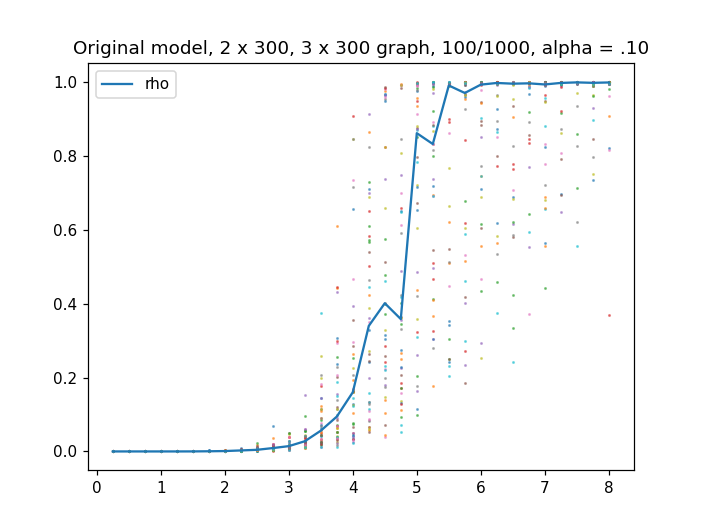

In [78]:
plot_means(partition(0, 8, 32), cut_alpha(res, 0), 2, ['rho'], 'Original model, 2 x 300, 3 x 300 graph, 100/1000, alpha = .10', show_data=True)

In [24]:
alpha = [.1]
bs = partition(0, 10, 64)

In [11]:
graphs2 = Pool(32).map(GraphByDegrees, [{2: 500}] * 500)

In [25]:
res = calc('fun', alpha, bs, graphs2345, 10000, set_builder=total, keys=['rho'])

#1 passed in 237.5161533355713,  projected end in 35.627427756786346 minutes
#2 passed in 234.80043983459473,  projected end in 31.488020435969034 minutes
#3 passed in 234.69821572303772,  projected end in 27.495218364397683 minutes
#4 passed in 233.19851970672607,  projected end in 23.50548877120018 minutes
#5 passed in 234.31696033477783,  projected end in 19.575626675287882 minutes
#6 passed in 233.9847264289856,  projected end in 15.650260146458944 minutes
#7 passed in 234.77534699440002,  projected end in 11.737856365953174 minutes
#8 passed in 233.92732572555542,  projected end in 7.821789153416952 minutes
#9 passed in 233.7592318058014,  projected end in 3.909240510728624 minutes
#10 passed in 235.5847611427307,  projected end in 0.0 minutes
time elapsed = 2346.608808040619


In [21]:
graphs2345 = Pool(32).map(GraphByDegrees, [{2: 200, 3: 200, 4: 200, 5: 200}] * 10)

<IPython.core.display.Javascript object>


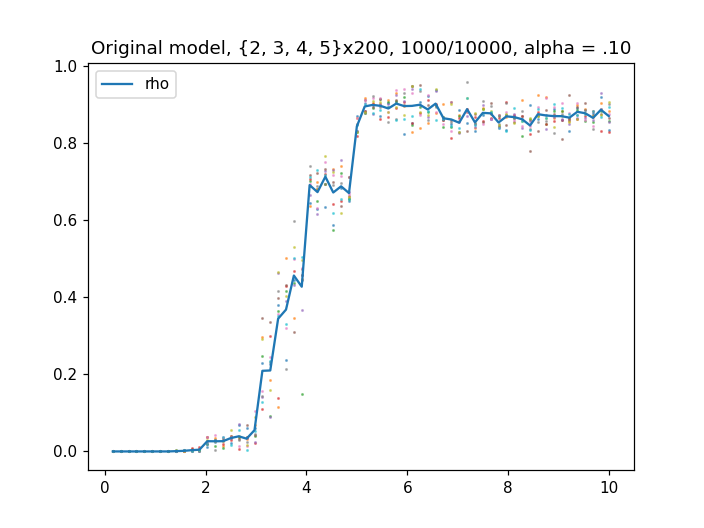

In [26]:
plot_means(bs, cut_alpha(res, 0), 10, ['rho'], 'Original model, {2, 3, 4, 5}x200, 1000/10000, alpha = .10', show_data=True)